In [1]:
import astropy.io.fits as fits
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import simple_norm
import ccdproc as ccd
from astropy import visualization as viz
from astropy.visualization import (imshow_norm, MinMaxInterval, SqrtStretch, ZScaleInterval)
from astropy.coordinates import SkyCoord
from photutils.aperture import ApertureStats
from astropy.stats import SigmaClip
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u

In [2]:
# Sunset is 7:09 PM 
# By at observatory at 6:39 PM to take sky flats
# Ideally be done by 10 PM 

In [3]:
data = ascii.read('landoltstars.txt')  

In [4]:
star_pos = SkyCoord('16h41m41.24s', '36:27:35.5', unit=(u.hourangle, u.deg))
star_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (250.42183333, 36.45986111)>

In [5]:
data[0]

<Row index=0>
StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
     str11        str8      str9   float64 float64 float64 float64 float64 float64
--------------- -------- --------- ------- ------- ------- ------- ------- -------
         TPHE A 00:30:09 -46:31:22  14.651   0.793    0.38   0.435   0.405   0.841

In [6]:
len(data)

526

In [7]:
st = SkyCoord(data[0]['RA(2000)'], data[0]['Dec(2000)'], unit=(u.hourangle, u.deg))
st

<SkyCoord (ICRS): (ra, dec) in deg
    (7.5375, -46.52277778)>

In [8]:
st.separation(star_pos).hour

8.874273021712979

In [9]:
lands = []
for star in data:
    ra = star['RA(2000)']
    dec = star['Dec(2000)']
    coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    #dist.append(coord.separation(star_pos))
    if star['V'] < 9.5 and coord.separation(star_pos).degree < 60:
        print(star)
        print('Separation:',coord.separation(star_pos).degree)
        lands.append(star)

StarDesignation RA(2000) Dec(2000)   V    B-V   U-B   V-R   R-I   V-I 
--------------- -------- --------- ----- ----- ----- ----- ----- -----
        109 231 17:45:20 -00:26:13 9.332 1.462 1.593 0.785 0.704 1.492
Separation: 39.74439851862938
StarDesignation RA(2000) Dec(2000)   V    B-V   U-B   V-R   R-I   V-I 
--------------- -------- --------- ----- ----- ----- ----- ----- -----
        111 773 19:37:17 +00:10:38 8.963 0.206 -0.21 0.119 0.144 0.262
Separation: 54.45338332240191


In [10]:
lands

[<Row index=388>
 StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
      str11        str8      str9   float64 float64 float64 float64 float64 float64
 --------------- -------- --------- ------- ------- ------- ------- ------- -------
         109 231 17:45:20 -00:26:13   9.332   1.462   1.593   0.785   0.704   1.492,
 <Row index=431>
 StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
      str11        str8      str9   float64 float64 float64 float64 float64 float64
 --------------- -------- --------- ------- ------- ------- ------- ------- -------
         111 773 19:37:17 +00:10:38   8.963   0.206   -0.21   0.119   0.144   0.262]

### Landolt Star Photometry

$V_{Landolt} = V_{Observed} + a (X-1) + b (X-1) (V_{Landolt}-I_{Landolt}) + ZP$

In [11]:
# For standard correction
# air mass
# airmass and color
# vega? 

## Data Reduction

In [12]:
directory = '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/*'
glob(directory)

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/bias',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/dark',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_I',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_V',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/Observation Plan (10_6).docx',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/ObservationPlan.pdf',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/vega']

In [13]:
files_bias = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/bias/*')
files_dark = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/dark/*')
files_flatI =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_I/*')
files_flatV =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_V/*')
files_m2 =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/*')
files_m2_I = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/*')
files_m2_V = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Vband/*')
files_vega =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/vega/*')

In [14]:
ccd_shape = fits.getdata(files_bias[0]).shape

### Bias

In [15]:
bias = np.zeros((len(files_bias), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_bias)):
    #print(files_bias[bb])
    bias[bb] = fits.getdata(files_bias[bb])

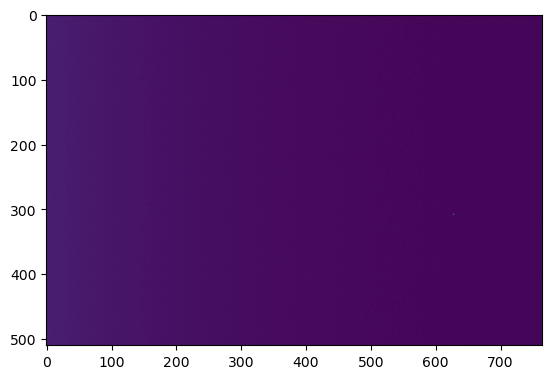

In [16]:
master_bias = np.median(bias, axis=0)
plt.imshow(master_bias)

In [17]:
master_bias.mean()

1088.0907497116493

### Darks

In [18]:
exptime_darkI = fits.getheader(files_m2_V[0])['EXPTIME']

In [19]:
exptime_darkV = fits.getheader(files_dark[0])['EXPTIME']

In [20]:
dark = np.zeros((len(files_dark), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_dark)):
    #print(files_bias[bb])
    dark[bb] = fits.getdata(files_dark[bb])

9.130502370882994

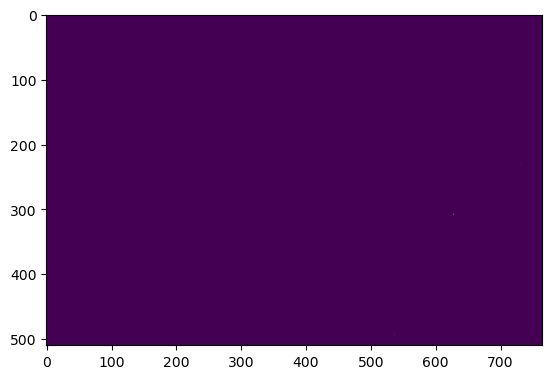

In [21]:
master_dark = np.median(dark-master_bias, axis=0)
plt.imshow(master_dark)
np.mean(master_dark)

### Flats

In [22]:
exptime_flatI = fits.getheader(files_flatI[0])['EXPTIME']

In [23]:
flatI = np.zeros((len(files_flatI), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_flatI)):
    #print(files_bias[bb])
    flatI[bb] = fits.getdata(files_flatI[bb]) - master_bias - exptime_flatI/exptime_darkI * master_dark

30056.210125195445

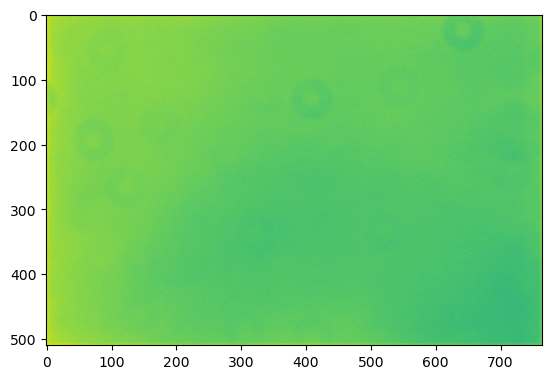

In [24]:
master_flatI = np.median(flatI, axis=0)
plt.imshow(master_flatI)
np.mean(master_flatI)

0.9999999999999997

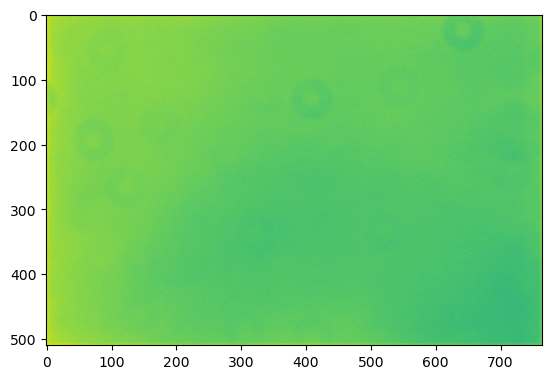

In [25]:
master_flatI_norm = master_flatI/np.mean(master_flatI)
plt.imshow(master_flatI_norm)
np.mean(master_flatI_norm)

In [26]:
exptime_flatV = fits.getheader(files_flatV[0])['EXPTIME']

In [27]:
flatV = np.zeros((len(files_flatV), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_flatV)):
    #print(files_bias[bb])
    flatV[bb] = fits.getdata(files_flatV[bb]) - master_bias - exptime_flatV/exptime_darkV * master_dark

25671.547239965388

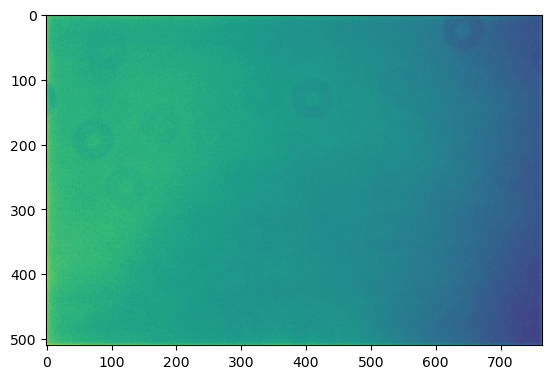

In [28]:
master_flatV = np.median(flatV, axis=0)-master_bias
plt.imshow(master_flatV)
np.mean(master_flatV)

1.0000000000000002

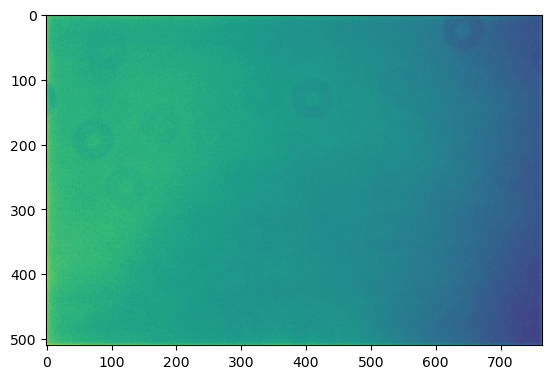

In [29]:
master_flatV_norm = master_flatV/np.mean(master_flatV)
plt.imshow(master_flatV_norm)
np.mean(master_flatV_norm)

A Note about the flats:

These flats were taken as sky flats before astronomical twilight. As part of the process of aiming the telescope at the North star to center it, the CCD was removed from the back of the telescope. Afterwards, it was placed back on, but imperfectly so that the dust on the optics was not in the same place. In the calibrated science images to follow, the "donuts" from dust particles on the optics are visible because of this.

### Calibration

$[(flat-bias)-\frac{t_f}{t_d}(dark-bias)]_{ave}[\frac{(object-bias)-\frac{t_o}{t_d}(dark-bias)}{(flat-bias)-\frac{t_f}{t_d}(dark-bias)}]_{pix}$

$[master\_flat-\frac{exptime\_flat}{exptime\_dark}(master\_dark)]_{ave}[\frac{(object-master\_bias)
-\frac{exptime\_obj}{exptime\_dark}(master\_dark)}{(master\_flat)-\frac{exptime\_flat}{exptime\_dark}(master\_dark)}]_{pix}$

In [30]:
files_m2_I

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_001.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_002.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_003.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_004.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_001.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_002.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_003.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_004.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_005.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_006.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband

In [31]:
data_m2_I = np.zeros((len(files_m2_I), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_I)):
    data_m2_I[ff] = (fits.getdata(files_m2_I[ff])-master_dark) / master_flatI_norm

Very blurry because the telescope does not track well. Need to have something that accounts for the movement of the stars in every science frame.


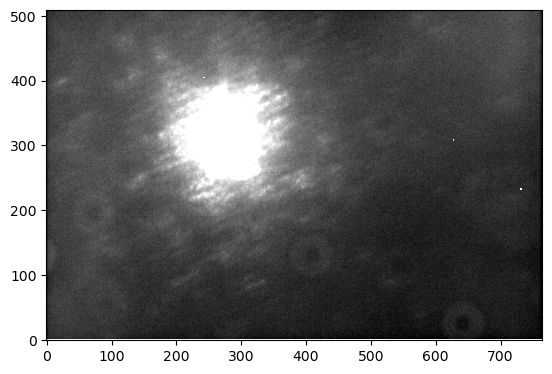

In [32]:
norm_ex = np.median(data_m2_I, axis=0)
imshow_norm(norm_ex, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
print('Very blurry because the telescope does not track well. Need to have something that accounts for the movement of the stars in every science frame.')

(<matplotlib.image.AxesImage at 0x7f15012b5850>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f14f615b940>)

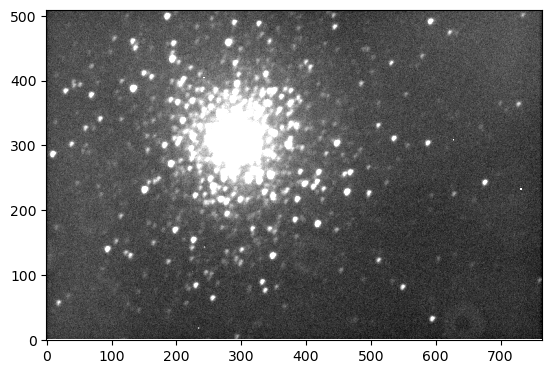

In [33]:
im1 = data_m2_I[0]
imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [34]:
bkg_sigma = mad_std(im1)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(im1)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
#print(sources)

In [35]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  

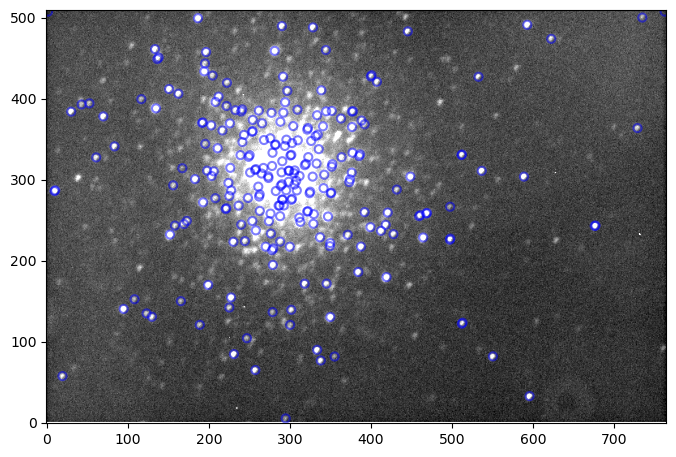

In [36]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
#annulus_aperture.plot(color='blue', lw=1.5, alpha=0.1)
print('')

In [37]:
star = (677, 243)#(597, 34)

In [38]:
dist = np.sqrt((positions[:,0]-star[0])**2 + (positions[:,1]-star[1])**2)
index = np.where(np.min(dist) == dist)
pos = positions[index][0]
#star_pos.append(pos)
#ids.append(index)

In [39]:
pos

array([677.12612501, 243.45973218])

In [40]:
from astropy.visualization import ImageNormalize

In [98]:
#imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
#shifted = []
data_m2_I = np.zeros((len(files_m2_I), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_I)):
    im = (fits.getdata(files_m2_I[ff])-master_dark) / master_flatI_norm
    bkg_sigma = mad_std(im)  
    daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
    sources = daofind(im)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=5.) 
    dist = np.sqrt((positions[:,0]-star[0])**2 + (positions[:,1]-star[1])**2)
    index = np.where(np.min(dist) == dist)
    pos = positions[index][0]
    aper = CircularAperture(positions, r=5.) 
    #aper[index].plot(color='blue', lw=1.5, alpha=0.5)
    
    shi = np.roll(im, (int(star[1]-pos[1]), int(star[0]-pos[0])), axis=(0,1))
    
    #fig, axs = plt.subplots(1, 2, figsize=(9,9))
    #axs[0].imshow(im, norm=ImageNormalize(data=im, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[0].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[0].scatter(star[0], star[1], marker='.', color='red', alpha=0.5)
    #axs[1].imshow(shi, norm=ImageNormalize(data=shi, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[1].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[1].scatter(star[0], star[1], marker='.', color='red', alpha=0.5)
    
    data_m2_I[ff] = shi
    #print(im)
    
    #np.roll(im, pos-star)

In [99]:
#star_V = (594, 290)
star_V = (555, 70)
#star_V = (355, 177)
#star_V = (600, 21)
#star_V = (599, 479)
#star_V = (682, 230)

In [100]:
#imshow_norm(fits.getdata(files_m2_V[0]), origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
#shifted = []
data_m2_V = np.zeros((len(files_m2_V), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_V)):
    im = (fits.getdata(files_m2_V[ff])-master_dark) / master_flatV_norm
    bkg_sigma = mad_std(im)  
    daofind = DAOStarFinder(fwhm=4., threshold=2.5 * bkg_sigma)  
    sources = daofind(im)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=5.) 
    dist = np.sqrt((positions[:,0]-star_V[0])**2 + (positions[:,1]-star_V[1])**2)
    index = np.where(np.min(dist) == dist)
    pos = positions[index][0]
    aper = CircularAperture(positions, r=5.) 
    #aper[index].plot(color='blue', lw=1.5, alpha=0.5)
    
    print(np.sqrt((pos[0]-star_V[0])**2 + (pos[1]-star_V[1])**2))
    shi = np.roll(im, (int(star_V[1]-pos[1]), int(star_V[0]-pos[0])), axis=(0,1))
    
    #fig, axs = plt.subplots(1, 2, figsize=(9,9))
    #axs[0].imshow(im, norm=ImageNormalize(data=im, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[0].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[0].scatter(star_V[0], star_V[1], marker='.', color='red', alpha=0.5)
    #axs[1].imshow(shi, norm=ImageNormalize(data=shi, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[1].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[1].scatter(star_V[0], star_V[1], marker='.', color='red', alpha=0.5)
    
    if np.sqrt((pos[0]-star_V[0])**2 + (pos[1]-star_V[1])**2) > 30.:
        print('Selected star too far away')
    else: 
        data_m2_V[ff] = shi
    #print(im)
    
    #np.roll(im, pos-star)

26.53738398585733
21.83304490504877
21.953036079431303
46.23193614817681
Selected star too far away
12.23206935111877
10.70735201945291
9.572564077172094
9.091323261693075
8.902041990812997
43.06073330763313
Selected star too far away
1.3256166289841604
5.831531623950198
11.455285389002357
5.18858963701437
5.318678335272187
5.538186868950662
14.841000883137074
14.090627098947493
11.151455903061647
9.690312857984582


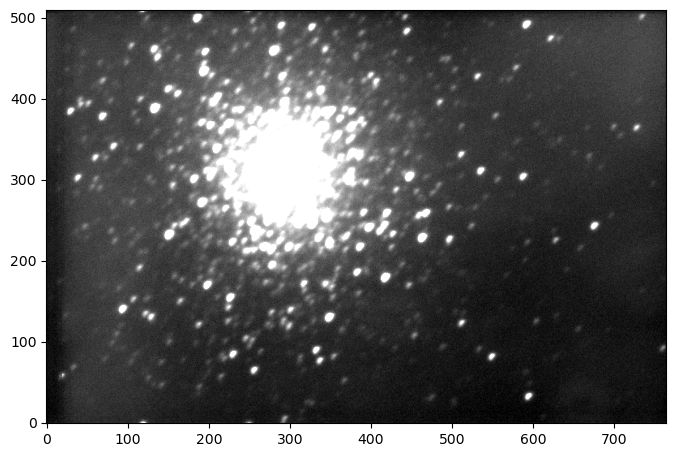

In [101]:
image_combined_I = np.median(data_m2_I, axis=0)
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

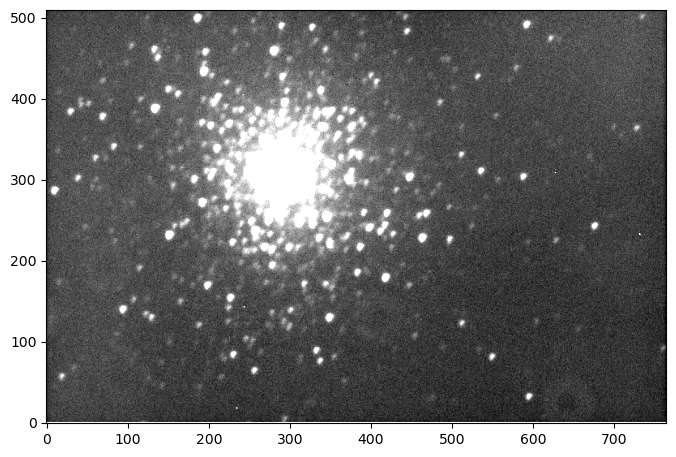

In [102]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(data_m2_I[0], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

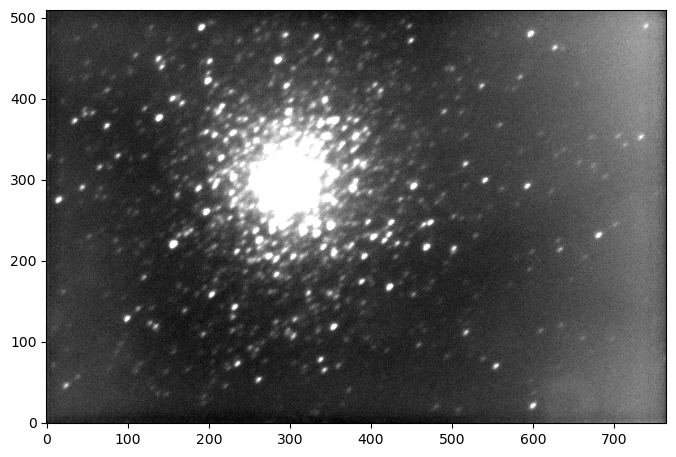

In [103]:
image_combined_V = np.median(data_m2_V, axis=0)
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

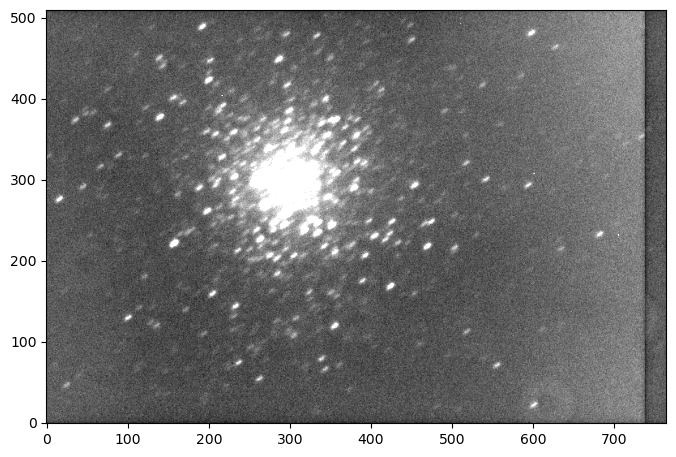

In [104]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(data_m2_V[0], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

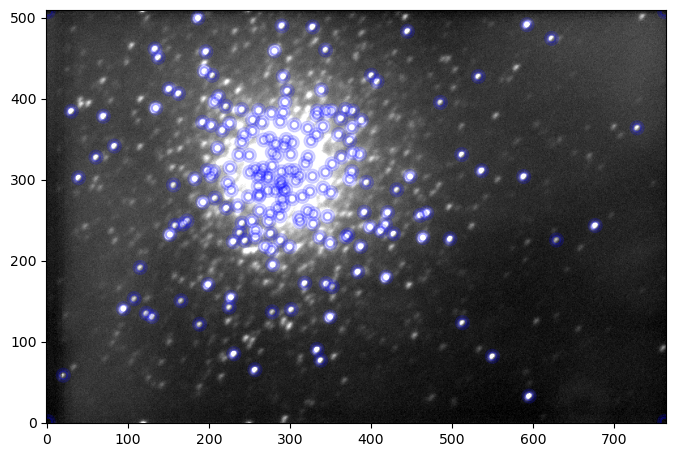

In [105]:
bkg_sigma = mad_std(image_combined_I)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(image_combined_I)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [106]:
aperstats = ApertureStats(image_combined_I, annuli)
bkg_mean = aperstats.mean
phot_table_I = aperture_photometry(image_combined_I, apertures)
aperture_area = apertures.area_overlap(image_combined_I)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_I['aperture_sum'] - total_bkg
phot_table_I['total_bkg'] = total_bkg
phot_table_I['aperture_sum_bkgsub'] = phot_bkgsub

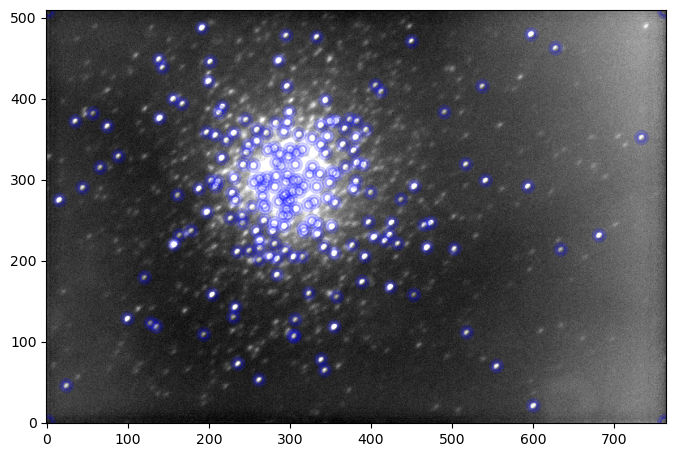

In [107]:
bkg_sigma = mad_std(image_combined_V)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(image_combined_V)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [108]:
aperstats = ApertureStats(image_combined_V, annuli)
bkg_mean = aperstats.mean
phot_table_V = aperture_photometry(image_combined_V, apertures)
aperture_area = apertures.area_overlap(image_combined_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_V['aperture_sum'] - total_bkg
phot_table_V['total_bkg'] = total_bkg
phot_table_V['aperture_sum_bkgsub'] = phot_bkgsub

In [109]:
color = phot_table_V['aperture_sum_bkgsub'] - phot_table_I['aperture_sum_bkgsub']
magnitude = phot_table_V['aperture_sum_bkgsub']

ValueError: operands could not be broadcast together with shapes (204,) (209,) 

In [112]:
x_VIshift = phot_table_V[4]['xcenter'] - phot_table_I[4]['xcenter']
y_VIshift = phot_table_V[4]['ycenter'] - phot_table_I[4]['ycenter']

In [113]:
x_VIshift

<Quantity 5.18889173 pix>

In [114]:
y_VIshift

<Quantity -12.35472029 pix>

In [115]:
int(star_V[1]-pos[1])

-8

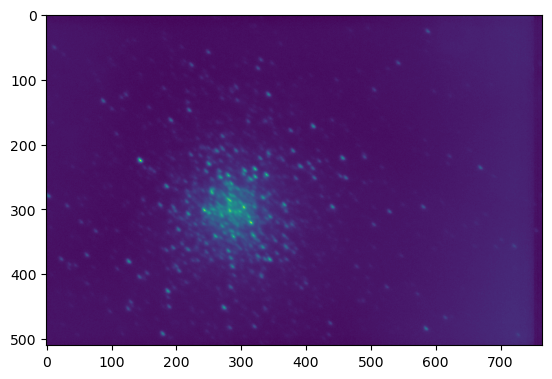

In [116]:
r = np.roll(image_combined_V, (int(x_VIshift.value), int(y_VIshift.value)), axis=(0,1))
plt.imshow(r)

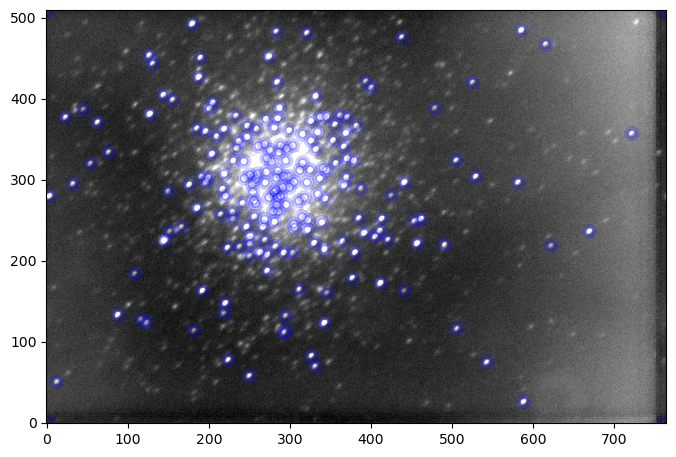

In [117]:
bkg_sigma = mad_std(r)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(r)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(r, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [118]:
aperstats = ApertureStats(image_combined_V, annuli)
bkg_mean = aperstats.mean
phot_table_V = aperture_photometry(image_combined_V, apertures)
aperture_area = apertures.area_overlap(image_combined_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_V['aperture_sum'] - total_bkg
phot_table_V['total_bkg'] = total_bkg
phot_table_V['aperture_sum_bkgsub'] = phot_bkgsub

In [120]:
color = []
for st in range(len(phot_table_V)):
    xV = phot_table_V[st]['xcenter']
    yV = phot_table_V[st]['ycenter']
    
    for ar in range(len(phot_table_I)):
        xI = phot_table_I[ar]['xcenter']
        yI = phot_table_I[ar]['ycenter']
    
        dist = np.sqrt((xV-xI)**2+(yV-yI)**2)
        if dist.value < 5.:
            print(dist)
        

0.0067918193496611734 pix
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
0.017027579921950038 pix
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
e

KeyboardInterrupt: 